In [1]:
# Preprocessing
import pandas as pd
import tables
from pyproj import Proj, transform
import time
import numpy as np
import gc
from tqdm import tqdm_notebook
from data_processing import get_data_2dprojection

In [2]:
#DATA_DIR = '/storage/home/vprov/JUNO/JUNO_students/data/'
TRAIN_DIR = '/srv/hd5/data/vprov/data/phase_1/train/'
tr_lpmt_hits = pd.read_hdf(TRAIN_DIR + 'lpmt_hits.h5', mode='r') 
tr_spmt_hits = pd.read_hdf(TRAIN_DIR + 'spmt_hits.h5', mode='r')
tr_pos = pd.read_csv(TRAIN_DIR + 'pmts_pos.csv') 
#tr_spmt_pos = pd.read_csv(TRAIN_DIR + 'spmt_pos.csv') 
tr_true_info = pd.read_csv(TRAIN_DIR + 'true_info.csv')

In [3]:
def lat(x,y,z):
    return np.arcsin(z/np.sqrt(x**2 + y**2 + z**2))

def lon(x,y,z):
    return np.arctan2(y,x)

In [4]:
tr_true_info['R'].mean()

13297.668783906875

In [5]:
gc.collect()

0

In [6]:
data_lpmt, event_to_id = get_data_2dprojection(tr_lpmt_hits, 
                                                        tr_spmt_hits, 
                                                        tr_pos, 
                                                        tr_true_info,
                                                        use_spmt=True)

Make projection
Starting cycle...


In [7]:
#np.save(TRAIN_DIR + 'lpmt_2d_1802', data_lpmt)

In [8]:
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [9]:
#Training

In [10]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [11]:
#gpu_fraction = 0.1
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)
#sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [12]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [13]:
tr_true_info['id'] = [event_to_id[evtID] for evtID in tr_true_info['evtID']]

In [14]:
tr_true_info[:3]

,E,R,evtID,x,y,z,id
0,4.747791,14610.378,0,8290.779,11995.6180,911.74286,0
1,3.919721,14630.141,1,11397.632,5407.4497,-7409.08200,1
2,6.823932,14573.132,2,14063.338,-3812.8540,246.65280,2


In [15]:
y_val = tr_true_info[['E']].values

In [16]:
y_val.shape

(16000, 1)

In [17]:
#y_val = np.load('/srv/hd5/data/vprov/y_val.np.npy')
#data_lpmt = np.load('/srv/hd5/data/vprov/lpmt_proj.np.npy')

In [18]:
data_lpmt.shape

(16000, 151, 151, 1)

In [19]:
#data_lpmt = data_lpmt.reshape((*data_lpmt.shape, 1))
#data_lpmt = data_lpmt.reshape((16000,151,151,1))

In [20]:
import keras
import keras.layers as L
from keras.models import Sequential

Using TensorFlow backend.


In [21]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [22]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 39397454303933782, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7410027725
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14934634858885068208
 physical_device_desc: "device: 0, name: Tesla K40m, pci bus id: 0000:02:00.0, compute capability: 3.5"]

In [30]:
model = Sequential()
model.add(L.Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=256, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=256, kernel_size=(3,3),activation='relu'))
model.add(L.MaxPool2D())
model.add(L.Conv2D(filters=512, kernel_size=(3,3),activation='relu'))
#model.add(L.Dropout(0.3))
model.add(L.Flatten())
model.add(L.Dense(512, activation='relu'))
#model.add(L.Dropout(0.3))
model.add(L.Dense(256, activation='relu'))
model.add(L.Dense(128, activation='relu'))
model.add(L.Dense(1))

In [31]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [32]:
model.build(input_shape=(None, 151,151,1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 149, 149, 128)     1280      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 128)       147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 256)       590080    
__________

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data_lpmt, y_val, test_size=0.3, random_state=45)

In [27]:
X_train.shape, y_train.shape

((11200, 151, 151, 1), (11200, 1))

In [81]:
!rm log_203.csv

In [82]:
from keras.callbacks import CSVLogger

csv_logger = CSVLogger('log_203E.csv', append=True, separator=';')

In [ ]:
out = model.fit(X_train, y_train, batch_size=32, 
                epochs=30, 
                callbacks=[csv_logger], 
                validation_data=(X_test, y_test))

Train on 11200 samples, validate on 4800 samples
Epoch 1/30
11200/11200 [==============================] - 73s 6ms/step - loss: 497.1986 - val_loss: 1.7034
Epoch 2/30
11200/11200 [==============================] - 72s 6ms/step - loss: 0.9862 - val_loss: 0.7694
Epoch 3/30
11200/11200 [==============================] - 72s 6ms/step - loss: 0.9359 - val_loss: 0.7087
Epoch 4/30
11200/11200 [==============================] - 72s 6ms/step - loss: 0.7974 - val_loss: 0.6352
Epoch 5/30
 7744/11200 [===================>..........] - ETA: 18s - loss: 0.5934

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

In [88]:
cs = pd.read_csv('log_203E.csv', sep=';')

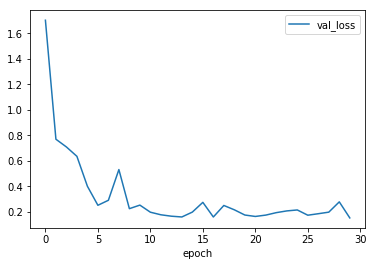

In [89]:
cs.plot(x='epoch',y='val_loss')
#plt.ylim((0, 100000))

In [90]:
model.save_weights('02_03_E.h5')

In [33]:
model.load_weights('18_02_E.h5')

In [ ]:
print("+")

In [91]:
with open("02_03_E.json", "w") as json_file:
    json_file.write(model.to_json())

In [34]:
from sklearn.metrics.pairwise import paired_euclidean_distances

In [35]:
from sklearn.metrics import mean_squared_error

In [36]:
# in mm
#test_results = paired_euclidean_distances(model.predict(X_test), y_test)

In [37]:
preds = np.maximum(model.predict(X_test), 0)
test_resultsE = mean_squared_error(preds[:,0], y_test[:,0])
#test_resultsR = mean_squared_error(preds[:,1], y_test[:,1])

In [41]:
test_resultsE.mean()

0.10578900484730176

(-1, 1)

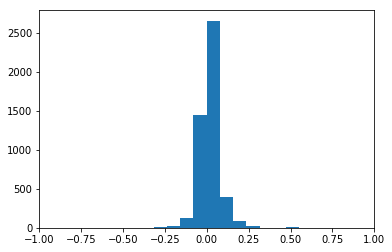

In [50]:
plt.hist((preds[:,0] - y_test[:,0])/y_test[:,0], bins=100)
plt.xlim((-1,1))

In [69]:
anti_ejection_mask = (abs(diff)<0.3) & (y_test[:,0] < 1.5) & (y_test[:,0] > 0.5)

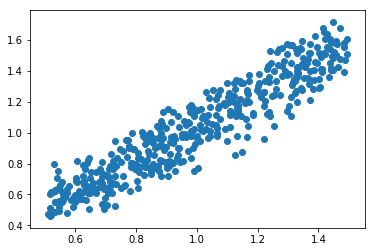

In [70]:
plt.scatter(y_test[:,0][anti_ejection_mask], preds[:,0][anti_ejection_mask])

In [71]:
np.std((preds[:,0][anti_ejection_mask] - y_test[:,0][anti_ejection_mask])/y_test[:,0][anti_ejection_mask])

0.11789867748896025

In [76]:
#test_resultsR.mean()

101617.658293631

In [97]:
#test_resultsR.mean() /100000 + test_resultsE.mean() * 100

In [98]:
# Make a submission
TEST_DIR = '/srv/hd5/data/vprov/data/phase_1/test/'
te_lpmt_hits = pd.read_hdf(TEST_DIR + 'test_l_hits.h5', mode='r')
te_spmt_hits = pd.read_hdf(TEST_DIR + 'test_s_hits.h5', mode='r')

In [99]:
len(te_lpmt_hits['event'].unique())

5000

In [101]:
te_data_lpmt, te_event_to_id = get_data_2dprojection(te_lpmt_hits, 
                                                              te_spmt_hits, 
                                                              tr_pos, 
                                                              tr_true_info,
                                                              use_spmt=True, time=True)

Make projection
Starting cycle...


In [102]:
te_data_lpmt.shape

(5000, 151, 151, 3)

In [91]:
#te_data_lpmt = te_data_lpmt.reshape((*te_data_lpmt.shape, 1))

In [103]:
test_answer = model.predict(te_data_lpmt)

In [104]:
test_answer = np.maximum(test_answer, 0)

In [105]:
test_answer[:3]

array([[3.1486816],
       [6.8654876],
       [2.4813795]], dtype=float32)

In [111]:
forR = pd.read_csv('./submissions/03_02_mix.csv')

In [112]:
forR[:3]

,E,R,evtID
0,13554.038,13554.038,16000
1,15458.701,15458.701,16001
2,8600.067,8600.067,16002


In [113]:
x = te_lpmt_hits["event"].unique()
pred = pd.DataFrame({
            "evtID": x,
            "R": forR['R'],
            "E": test_answer[:,0]
    })

In [114]:
pred[:3]

,E,R,evtID
0,3.148682,13554.038,16000
1,6.865488,15458.701,16001
2,2.481380,8600.067,16002


In [115]:
pred.to_csv('./submissions/03_02_mix.csv', index=None)

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [109]:
test_resultsE

0.10578900484730176

In [112]:
np.maximum(preds[:,0], 0) - y_test[:,0]

array([ 0.07827002,  0.16265111,  0.09557195, ...,  0.29406197,
        0.4023328 , -0.02289935])

Text(0.5,0,'Energy error, mEv')

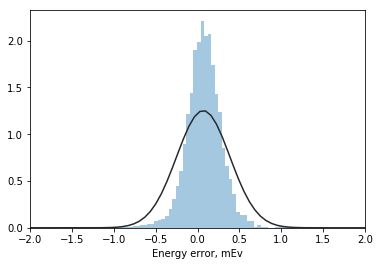

In [119]:
sns.distplot(np.maximum(preds[:,0], 0) - y_test[:,0], kde=False, fit=stats.norm, bins=300)
plt.xlim((-2,2))
plt.xlabel("Energy error, mEv")

In [122]:
(preds-y_test).mean() / y_test.mean()

0.012328221320621629

In [49]:
test_results.mean() / 10

40.478805095559686

In [53]:
results = model.predict(X_test)

In [54]:
xs = results[:,0] - y_test[:,0]

(-1000, 1000)

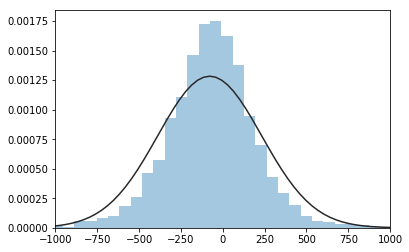

In [57]:
sns.distplot(xs, kde=False, fit=stats.norm, bins=100)
plt.xlim(-1000,1000)

In [59]:
abs(xs).mean()/10

21.422522304369796

In [ ]:
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
## load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")
# 
## evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)

In [ ]:
# Adversarial example с нормальным текстом
# Кэширование перевода
# Bert в телефоне